In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import inspect
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(1, parentdir+'/src')
import torch
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import time
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import gym
import pybullet as p
import stage.envs
from stage.tasks.twolink.reaching import TwoLinkReaching
from stage.utils.nn import use_gpu
use_gpu()

In [4]:
savepath = parentdir + '/data/twolink/'

In [5]:
task = TwoLinkReaching(render=False)

# Read task parameters, should we use a separate class to wrap this?

nq, nv, nu, nx = task.nq, task.nv, task.nu, task.nx
dt_control, dt_env = task.dt_control, task.dt_env
q_lb, q_ub = task.q_lb, task.q_ub
v_lb, v_ub = -100*torch.ones_like(q_lb), 100*torch.ones_like(q_ub)

In [6]:
# Setup action parameterization

from stage.controllers.actor import Actor
from stage.controllers.trivial import Identity
from stage.controllers.pd import PD


# na = 2
# action_ub = torch.Tensor(task.env.action_space.high)
# action_lb = torch.Tensor(task.env.action_space.low)
# actor = Actor(na, Identity(nq, nv, nu), action_lb, action_ub)

na = 4
gain_ub = 50 * torch.ones((nq))
gain_lb = 0. * torch.ones((nq))
action_ub = torch.cat((gain_ub, q_ub))
action_lb = torch.cat((gain_lb, q_lb))
actor = Actor(na, PD(nq, nv, nu), action_lb, action_ub)

task.cost.actor = actor 

In [7]:
# Setup model learning

from stage.dynamics.probabilistic_ensemble import ProbabilisticEnsemble, DefaultDx

ensemble_size = 5
nn_epochs = 10
batch_size = 64
    
dynamics = ProbabilisticEnsemble(nq, nv, na, dt_control, 
                                 DefaultDx,
                                 ensemble_size, 
                                 learning_rate = 0.001)

dynamics.state_lb = torch.cat((q_lb, v_lb))
dynamics.state_ub = torch.cat((q_ub, v_ub))

In [8]:
# Setup controller

from stage.controllers.mscem import MSCEM

plan_horizon = 50
n_particles = 10
pop_size = 400
assert n_particles % ensemble_size == 0

controller = MSCEM(dynamics, task.cost, actor,
                   plan_horizon, n_particles, pop_size)

In [9]:
# Setup learner

from stage.learners.learn_and_control_model import LearnAndControlModel
learner = LearnAndControlModel(task, dynamics, controller)

In [10]:
controller.regularize(1)
_ = learner.learn(10, verbose=True)
learner.save_training_data(savepath+'data_pd_reg')

Network training: 100%|██████████| 10/10 [00:00<00:00, 23.23epoch(s)/s, Training loss MSE=1.1147275]


Iteration:  0
avg. decision time:  0.004465031623840332
obs. reward:  -95.391304
act. reward:  -1.6179016


Network training: 100%|██████████| 10/10 [00:01<00:00,  7.67epoch(s)/s, Training loss MSE=0.7091835]


Iteration:  1
avg. decision time:  0.1947762370109558
obs. reward:  -149.1528
act. reward:  -2.6156998


Network training: 100%|██████████| 10/10 [00:01<00:00,  5.47epoch(s)/s, Training loss MSE=0.45450464]


Iteration:  2
avg. decision time:  0.19286091804504393
obs. reward:  -94.21474
act. reward:  -2.1864998


Network training: 100%|██████████| 10/10 [00:02<00:00,  4.30epoch(s)/s, Training loss MSE=0.4351452]


Iteration:  3
avg. decision time:  0.19244146347045898
obs. reward:  -76.81368
act. reward:  -1.9863981


Network training: 100%|██████████| 10/10 [00:02<00:00,  3.47epoch(s)/s, Training loss MSE=0.35996145]


Iteration:  4
avg. decision time:  0.1936694359779358
obs. reward:  -113.89933
act. reward:  -1.8237703


Network training: 100%|██████████| 10/10 [00:03<00:00,  2.91epoch(s)/s, Training loss MSE=0.28661785]


Iteration:  5
avg. decision time:  0.19287731647491455
obs. reward:  -72.54011
act. reward:  -1.6464096


Network training: 100%|██████████| 10/10 [00:03<00:00,  2.53epoch(s)/s, Training loss MSE=0.24247785]


Iteration:  6
avg. decision time:  0.19447775363922118
obs. reward:  -86.30867
act. reward:  -2.2578723


Network training: 100%|██████████| 10/10 [00:03<00:00,  2.60epoch(s)/s, Training loss MSE=0.20115015]


Iteration:  7
avg. decision time:  0.19587289094924926
obs. reward:  -121.76551
act. reward:  -2.4061806


Network training: 100%|██████████| 10/10 [00:05<00:00,  1.90epoch(s)/s, Training loss MSE=0.20645899]


Iteration:  8
avg. decision time:  0.1966627812385559
obs. reward:  -72.14511
act. reward:  -1.9641068


Network training: 100%|██████████| 10/10 [00:05<00:00,  1.75epoch(s)/s, Training loss MSE=0.13687073]

Iteration:  9
avg. decision time:  0.1966930079460144
obs. reward:  -75.40297
act. reward:  -1.5442929


In [11]:
controller.regularize(1)
traj, log = task.perform(task.goal, controller)
act_seq = traj[:, nx:nx+na]
initial_obs = traj[0, :nx]
final_obs = traj[-1, :nx]

avg. decision time:  0.19370596170425414
obs. reward:  -392.19678
act. reward:  -2.4471471


In [12]:
n_sample = 50
traj_pred = dynamics.unroll(initial_obs, 
                            act_seq, 
                            n_sample)

predicted_err = torch.norm(traj_pred[-1, :, :]-final_obs.expand(n_sample, -1), p=2, dim=1)
print (predicted_err.mean())
print (predicted_err.std())

tensor(4.5637, grad_fn=<MeanBackward0>)
tensor(1.1629, grad_fn=<StdBackward0>)


In [13]:
task_horizon = task.task_horizon

traj_pred_mean = torch.mean(traj_pred, dim=1)
traj_pred_std = torch.std(traj_pred, dim=1)
traj_pred_mean = traj_pred_mean.detach().cpu().numpy()
traj_pred_std = traj_pred_std.detach().cpu().numpy()
traj = traj.detach().cpu().numpy()

desired = task.cost.desired.repeat((task_horizon, 1))
desired = desired.detach().cpu().numpy()

In [14]:
font = {'family' : 'serif',
        'size'   : 22}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3, linewidth=200, suppress=True)

In [15]:
# traj_pred_mean = np.load('traj_pred_mean.npy')
# traj_pred_std = np.load('traj_pred_std.npy')
# traj = np.load('traj.npy')

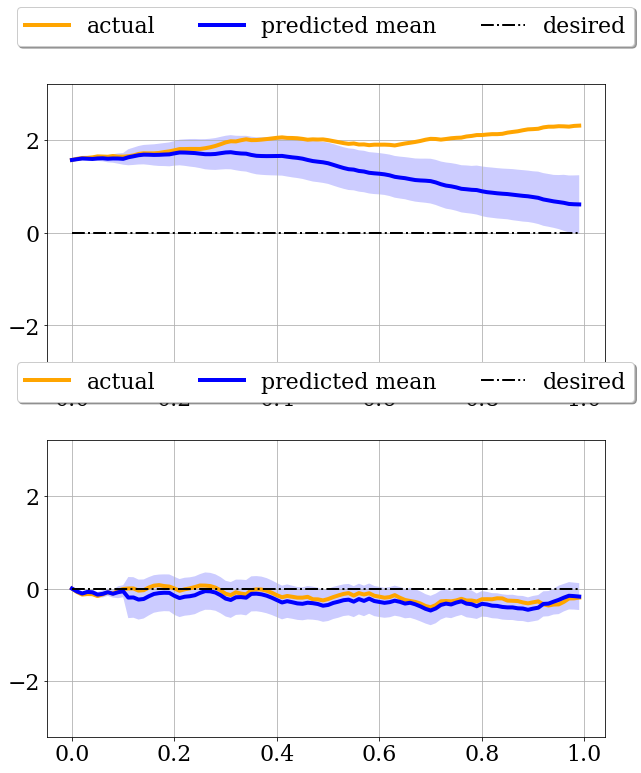

In [16]:
d = nq
dt = dt_control
fig, ax = plt.subplots(d, figsize=(10, d * 6))
t = np.arange(0.0, task_horizon*dt, dt)
dlb = traj_pred_mean - traj_pred_std
ub = traj_pred_mean + traj_pred_std

for i in range(d):
    ax[i].plot(t, traj[:, i], lw=4, color='orange', label='actual')
    ax[i].plot(t, traj_pred_mean[:, i], lw=4, color='b', label='predicted mean')
    ax[i].plot(t, desired[:, i], lw=2, color='k', ls='-.', label='desired')
    lb = traj_pred_mean - traj_pred_std
    ub = traj_pred_mean + traj_pred_std
    ax[i].fill_between(t, lb[:, i], ub[:, i], facecolor='blue',
                alpha=0.2)
    _ = ax[i].grid()
    _ = ax[i].set_ylim([-3.2, 3.2])
    ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
             ncol=3, fancybox=True, shadow=True)
# fig.savefig('prediction_with_reg_150steps' + '.png', bbox_inches='tight')